In [1]:
import numpy as np
import pandas as pd
from glob import glob
from datetime import timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# CCMar - Rio Grande

In [2]:
# Organizing measured data

df = pd.read_excel('./measured/Linígrafo_Maio_2024.xlsx')
start = '2024-05-01 00'
end = '2024-06-01 00'

df.dropna(subset=['Data', 'Hora'], inplace=True)
for index in df.index:
    time=df.loc[index, 'Hora']
    df.loc[index, 'datetime'] = df.loc[index, 'Data'].replace(hour=time.hour)
new_index = pd.date_range('2024-05-01 00', end, freq='1h')
df = df.set_index('datetime').reindex(new_index).reset_index().rename({'index':'datetime'}, 
                                                                      axis=1)[['Cota', 'datetime']]
df.rename({'Cota':'medido'}, axis=1, inplace=True)
df['medido'] = [float(medido.replace(',','.')) if type(medido) == str else medido for medido in df['medido']]

In [3]:
# Organizing modeled data

ccmar = pd.read_csv('./modeled/ccmar_20240618.ts3', header=20, sep=' ', 
            names=['Data', 'Hora', 'simulado'])

ccmar.columns=['Data', 'Hora', 'simulado']
ccmar['Data'] = ccmar['Data'].apply(str)
ccmar['datetime'] = [data+' '+hora for data,hora in zip(ccmar['Data'], ccmar['Hora'])]
ccmar['datetime'] = pd.to_datetime(ccmar['datetime'], format='%Y/%m/%d %H:%M:%S.%f')
ccmar = ccmar[['simulado', 'datetime']]
ccmar.set_index('datetime', inplace=True)

In [4]:
# Merge measured and modeled dataframes
merged = pd.merge(df, ccmar, on='datetime', how='outer')
merged.set_index('datetime', inplace=True)
merged.sort_index(inplace=True)
merged = merged.loc[start:end]
merged['simulado'] = merged['simulado']+1

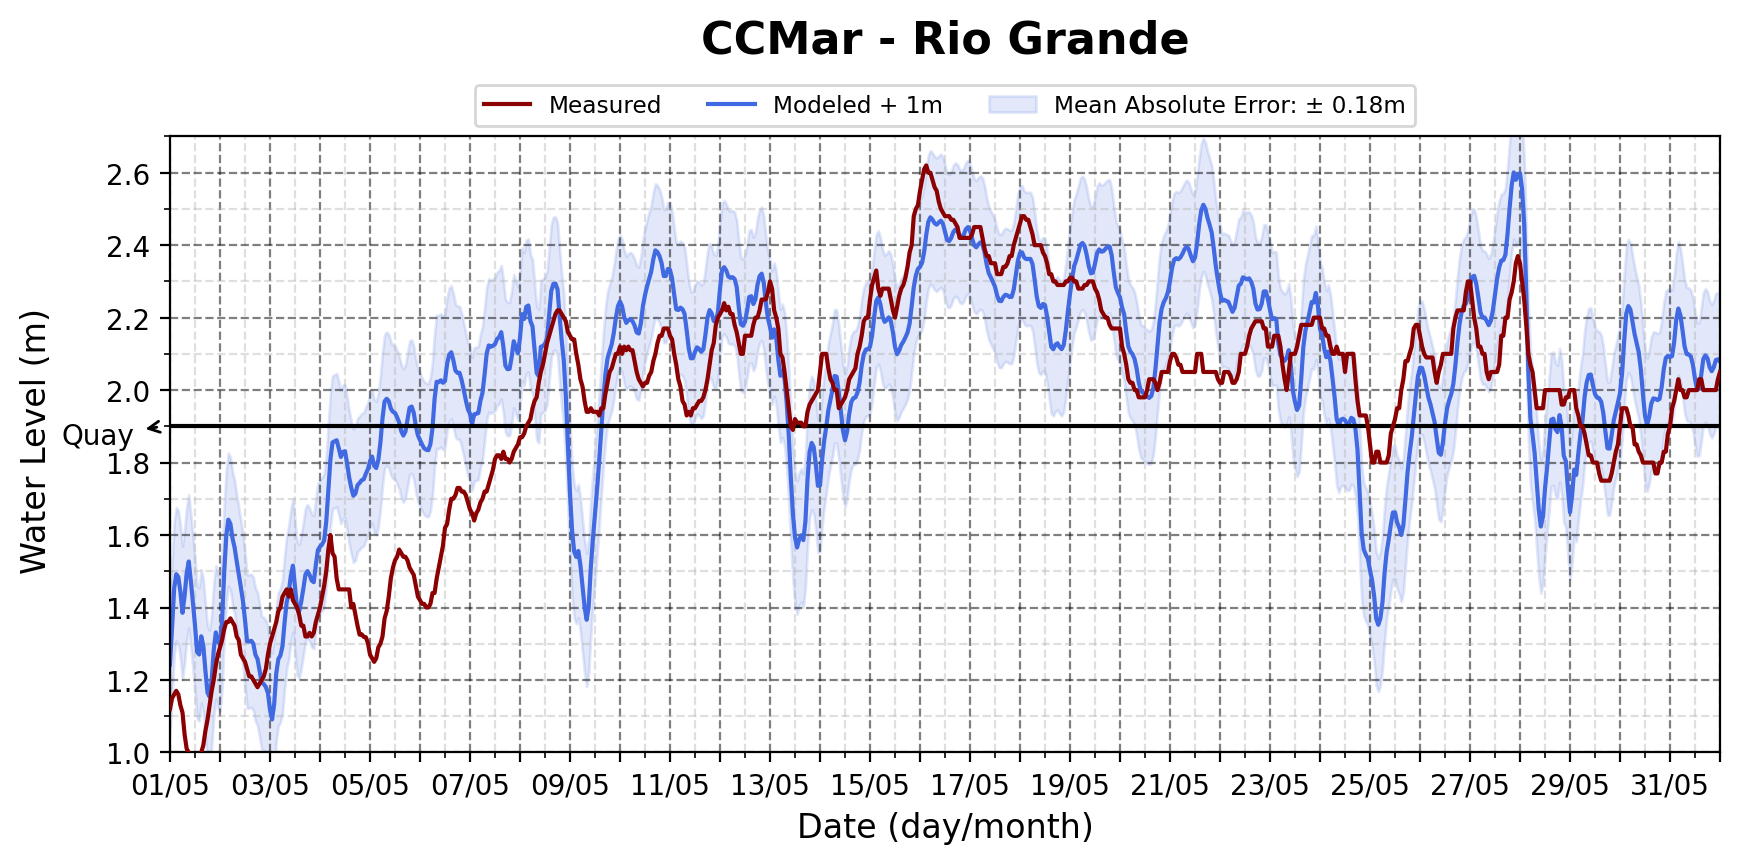

In [5]:
fig,ax = plt.subplots(nrows=1, dpi=200, sharex=True, sharey=False, figsize=(10, 4))

# Mean Absolute Error
subset = merged.dropna()
mae = mean_absolute_error(subset['medido'], subset['simulado'])

# Plot
ax.plot(merged.index, merged['medido'], '-', c='darkred', markersize=5, label='Measured', zorder=10**6)

ax.plot(merged.index, merged['simulado'], '-', c='royalblue', label='Modeled + 1m')
ax.fill_between(merged.index,merged['simulado']-mae, merged['simulado']+mae, 
                 alpha=0.15, color='royalblue', label='Mean Absolute Error: ± %.2fm' % mae)

ax.legend(loc='center', fontsize='small', ncol=3,
         bbox_to_anchor=[0.5, 1.05])


# Ticks e Labels
xlim = [pd.to_datetime(lim) for lim in (start,end)]
xticks = pd.date_range(xlim[0].replace(hour=0, minute=0, second=0), 
                       xlim[1].replace(hour=0, minute=0, second=0)+timedelta(hours=24), freq='24h')
xminorticks = pd.date_range(xticks[0], xticks[-1], freq='12h')
xlabels = [tick.strftime('%d/%m') for tick in xticks]
xlabels[1::2] = ['' for i in xlabels[1::2]]

yticks=np.arange(0, 4, 0.2).tolist()
ylabels=['%.2f' % tick for tick in yticks]
yminorticks = np.arange(0, 4, 0.1)

ax.set_xticks(ticks=xticks, labels=xlabels)
ax.set_xticks(ticks=xminorticks, minor=True)

ax.set_yticks(ticks=yticks)
ax.set_yticks(minor=True, ticks=yminorticks)
ax.set_ylim(1.0,2.7)

fig.text(0.05, 0.5, 'Water Level (m)', va='center', rotation='vertical', size=12)
ax.set_xlabel('Date (day/month)', size=12)
ax.set_title('CCMar - Rio Grande', weight='bold', size=16, loc='center', pad=30)

# Grid
ax.set_xlim(xlim)
ax.grid(True, linestyle='--', which='major', alpha=0.5, color='k')
ax.grid(True, linestyle='--', which='minor', alpha=0.4)

# Quay
ax.annotate('Quay', xy=(-0.005, 0.9/1.7), xytext=(-0.07, 0.85/1.7), xycoords='axes fraction', 
            color='k', fontsize=10,
             arrowprops={'arrowstyle':'<-'})
plt.hlines(1.9, xminorticks[0], xminorticks[-1], colors=['k'], linestyle='-')

# Save Figure
date_label = tuple([lim.strftime('%Y%m%d%H%M') for lim in xlim])
plt.savefig('./plots/may_ccmar_RG_%s_%s.jpeg' % date_label , dpi=200, bbox_inches='tight')

# Points

In [6]:
colors=['yellow', 'darkorange', 'darkred', 'darkblue', 
        'darkcyan', 'darkgreen', 'darkmagenta', 'deeppink', 'black']

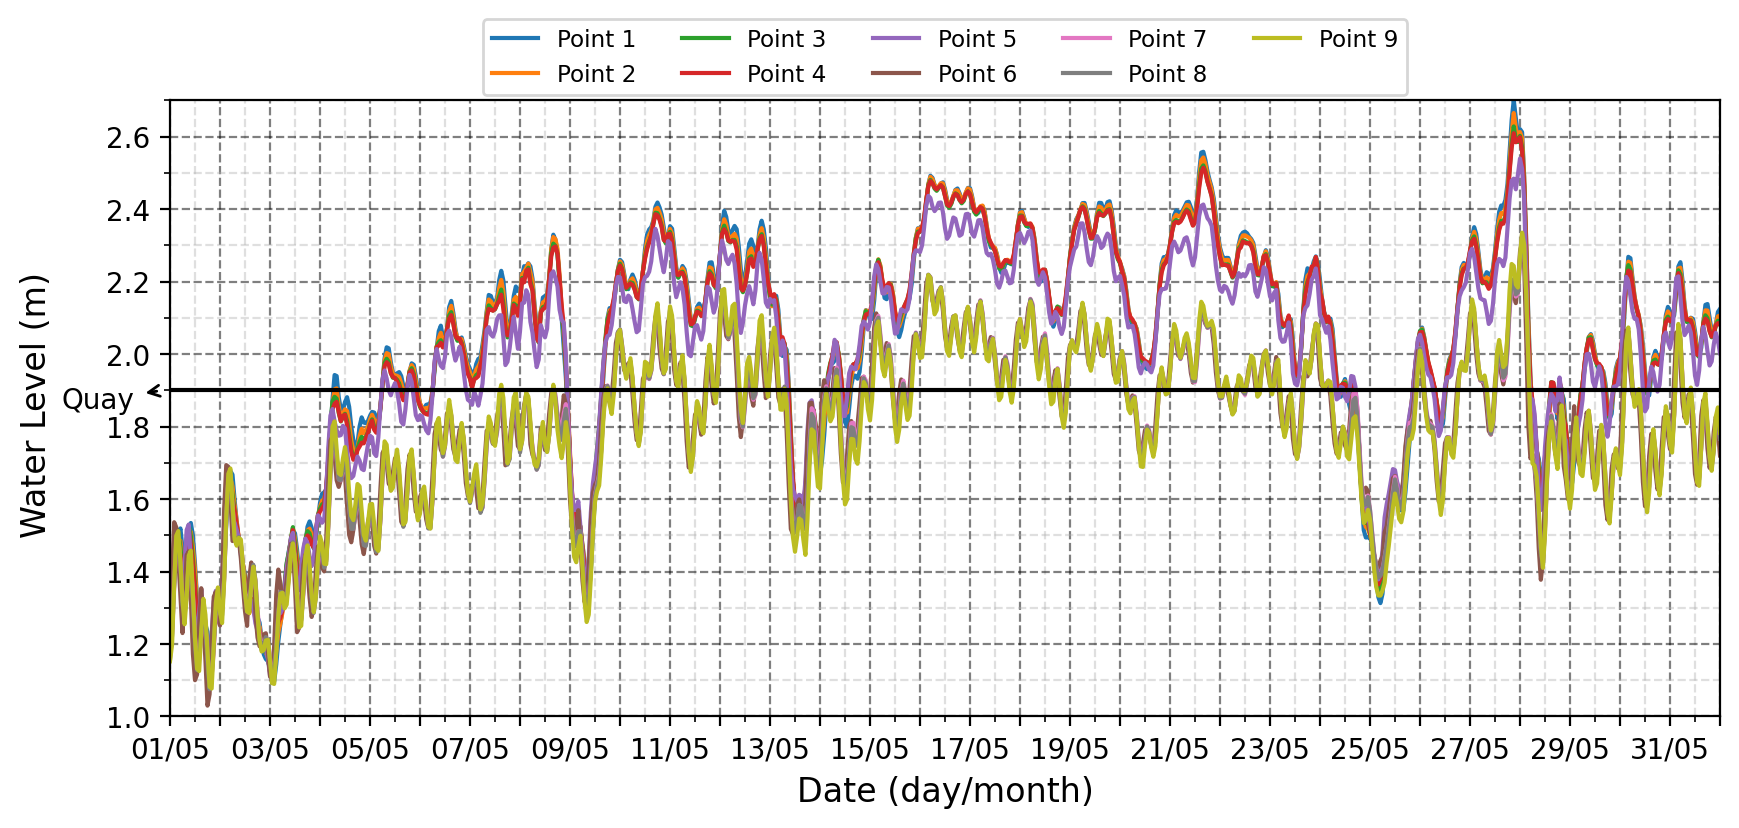

In [7]:
files = sorted(glob('./modeled/*ponto*.ts3')) # modeled data
fig,ax = plt.subplots(nrows=1, dpi=200, sharex=True, sharey=False, figsize=(10, 4))

i=0
for file,color in zip(files, colors):
    ponto = pd.read_csv(file, header=20, names=['Data', 'Hora', 'simulado'], sep=' ')
    # Organizing modeled data
    ponto['Data'] = ponto['Data'].apply(str)
    ponto['datetime'] = [data+' '+hora for data,hora in zip(ponto['Data'], ponto['Hora'])]
    ponto['datetime'] = pd.to_datetime(ponto['datetime'], format='%Y/%m/%d %H:%M:%S.%f')
    ponto = ponto[['simulado', 'datetime']]
    ponto.set_index('datetime', inplace=True)

    n = file.split('.ts3')[0][-1]

    # May
    xlim = ('2024-05-01 00', '2024-06-01 00') # Limites temporais
    ponto = ponto.loc[xlim[0]:xlim[1]]

    # Datum Correction
    ponto['simulado'] = ponto['simulado']+1

    ### Plot
    sns.lineplot(x=ponto.index, y=ponto['simulado'], label='Point %s'%n, ax=ax)
    ax.legend(loc='center', fontsize='small', ncol=5,
             bbox_to_anchor=[0.5, 1.07])

    i+=1
    
# Ticks e Labels
xlim = [pd.to_datetime(lim) for lim in xlim]
xticks = pd.date_range(xlim[0].replace(hour=0, minute=0, second=0), 
                           xlim[1].replace(hour=0, minute=0, second=0)+timedelta(hours=24), freq='24h')
xminorticks = pd.date_range(xticks[0], xticks[-1], freq='12h')
xlabels = [tick.strftime('%d/%m') for tick in xticks]
xlabels[1::2] = ['' for i in xlabels[1::2]]
    
yticks=np.arange(0, 4, 0.2).tolist()
ylabels=['%.2f' % tick for tick in yticks]
yminorticks = np.arange(0, 4, 0.1)
    
ax.set_xticks(ticks=xticks, labels=xlabels)
ax.set_xticks(ticks=xminorticks, minor=True)
    
ax.set_yticks(ticks=yticks)
ax.set_yticks(minor=True, ticks=yminorticks)
ax.set_ylim(1.0,2.7)

fig.text(0.05, 0.5, 'Water Level (m)', va='center', rotation='vertical', size=12)
ax.set_ylabel('')
ax.set_xlabel('Date (day/month)', size=12)
    
ax.set_title('', weight='bold', size=16, loc='center', pad=30)

# Quay
plt.hlines(1.9, xminorticks[0], xminorticks[-1], colors=['k'], linestyle='-')
ax.annotate('Quay', xy=(-0.005, 0.9/1.7), xytext=(-0.07, 0.85/1.7), xycoords='axes fraction', 
                color='k', fontsize=10,
                 arrowprops={'arrowstyle':'<-'})
    
# Grid
ax.set_xlim(xlim)
ax.grid(True, linestyle='--', which='major', alpha=0.5, color='k')
ax.grid(True, linestyle='--', which='minor', alpha=0.4)
    
# Save Figure
date_label = tuple([lim.strftime('%Y%m%d%H%M') for lim in xlim])
plt.savefig('./plots/may_points_%s_%s.jpeg' % date_label , dpi=200, bbox_inches='tight')